In [131]:
import pandas as pd

pd.options.display.max_columns = 500
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import gc
gc.collect()

33492

In [132]:
data=pd.read_csv('ShowsAndPrices.csv', delimiter=';' ,error_bad_lines=False)

In [57]:
data.head()

,Premium,Other,Bid,p11,p12,p13,p21,p22,p23,p24,agg,mean,target
0,1.0,0.0,20.00,102.183333,47.00,30.233333,20.716667,22.583333,18.866667,17.633333,2.259964e+10,37.030952,1.0
1,1.0,0.0,17.00,37.766667,20.90,16.416667,14.883333,12.950000,6.816667,4.600000,7.831407e+07,16.333333,1.0
2,8.0,0.0,38.26,53.900000,40.80,23.666667,16.383333,11.433333,5.950000,5.233333,3.035684e+08,22.480952,8.0
3,1.0,0.0,100.00,804.816667,369.15,286.033333,280.883333,385.583333,194.150000,188.983333,3.376926e+17,358.514286,1.0
4,2.0,0.0,60.00,971.550000,275.75,184.650000,146.866667,122.200000,84.516667,52.433333,3.934361e+15,262.566667,2.0


In [133]:
# Переведем все значения в числовой формат

for i in data.columns:
    try:
        data[i]=data[i].astype(str)
        data[i] = [x.replace(',', '.') for x in data[i]]
        data[i]=data[i].astype(float)
        #data[i]=boxcox(data[i], 0)
    except:
        next
# В Bid tcmn незначительное количество пропусков. Просто уберем их
data=data[data['Bid'] >0 ]

In [134]:
# Посичтаем пару метрик и из  '%p%' признаков
data['agg']=data['p11']*data['p12']*data['p13']*data['p21']*data['p22']*data['p23']*data['p24']
data['mean']=(data['p11']+data['p12']+data['p13']+data['p21']+data['p22']+data['p23']+data['p24'])/7

# Главным таргетом сделаем отличие стоимости Premium объявлений и Other. 
# Правильнм будут случаи, когда не ночь и стоимость Premium незначительно выше Other.
# Тогда при минимальных затратах будут объявлений наверху.
data['target'] = data['Premium'] - data['Other']

In [20]:
#Посмотрим на корреляцию между всеми признаками
data.corr()

,Premium,Other,Bid,p11,p12,p13,p21,p22,p23,p24,agg,mean,target
Premium,1.000000,0.095922,0.032662,0.018738,0.021639,0.024151,0.025393,0.021601,0.021446,0.020361,0.016414,0.023919,0.086604
Other,0.095922,1.000000,-0.005633,0.000594,0.000518,-0.000674,-0.000191,0.002810,0.001626,0.001003,-0.000334,0.000740,-0.983342
Bid,0.032662,-0.005633,1.000000,0.528040,0.555533,0.534952,0.498065,0.434936,0.417489,0.397893,0.206800,0.552588,0.011602
p11,0.018738,0.000594,0.528040,1.000000,0.847967,0.759026,0.695080,0.622822,0.578735,0.540361,0.296492,0.862906,0.002827
p12,0.021639,0.000518,0.555533,0.847967,1.000000,0.928453,0.862733,0.765988,0.724647,0.679048,0.427258,0.947315,0.003433
p13,0.024151,-0.000674,0.534952,0.759026,0.928453,1.000000,0.951415,0.844006,0.809807,0.762609,0.525773,0.957371,0.005085
p21,0.025393,-0.000191,0.498065,0.695080,0.862733,0.951415,1.000000,0.891509,0.870005,0.824938,0.613058,0.941760,0.004828
p22,0.021601,0.002810,0.434936,0.622822,0.765988,0.844006,0.891509,1.000000,0.941539,0.896946,0.663036,0.895239,0.001132
p23,0.021446,0.001626,0.417489,0.578735,0.724647,0.809807,0.870005,0.941539,1.000000,0.968332,0.786295,0.869601,0.002289
p24,0.020361,0.001003,0.397893,0.540361,0.679048,0.762609,0.824938,0.896946,0.968332,1.000000,0.831569,0.828788,0.002714


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192795 entries, 0 to 192812
Data columns (total 13 columns):
Premium    192795 non-null float64
Other      192795 non-null float64
Bid        192795 non-null float64
p11        192795 non-null float64
p12        192795 non-null float64
p13        192795 non-null float64
p21        192795 non-null float64
p22        192795 non-null float64
p23        192795 non-null float64
p24        192795 non-null float64
agg        192795 non-null float64
mean       192795 non-null float64
target     192795 non-null float64
dtypes: float64(13)
memory usage: 20.6 MB


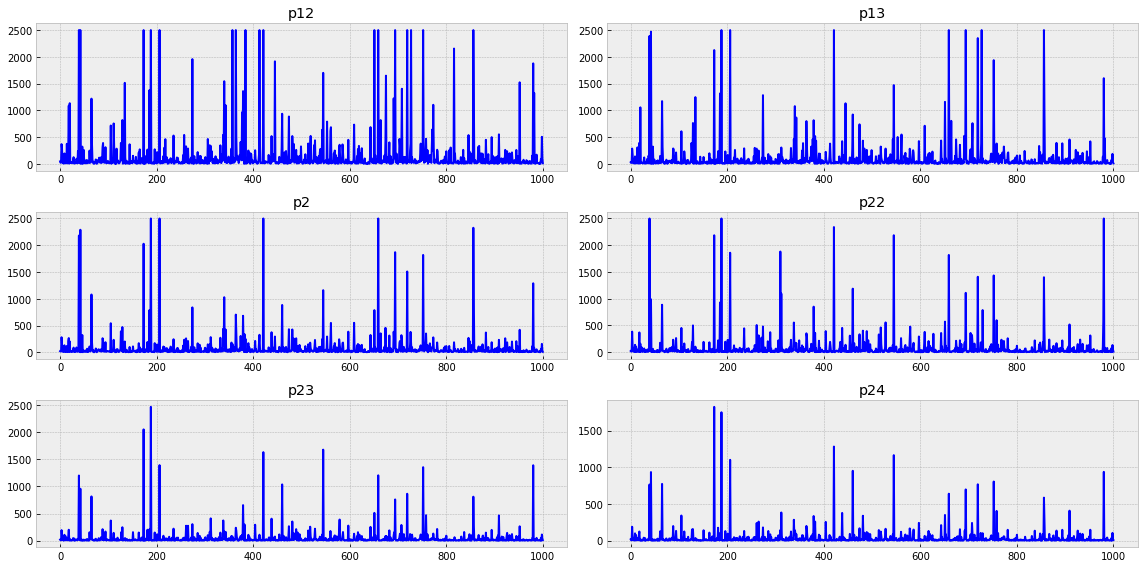

In [35]:
# Построим ряды
all_series = {
    "p12": data["p12"][:1000],
    "p13": data["p13"][:1000],
    "p2": data["p21"][:1000],    
    "p22": data["p22"][:1000],
    "p23": data["p23"][:1000],
    "p24": data["p24"][:1000]

}

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()





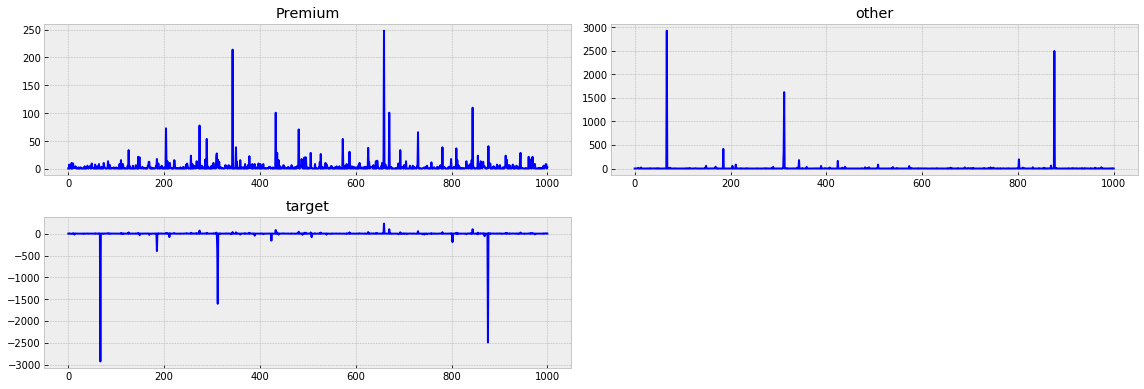

In [36]:
# Построим ряды
all_series = {
    "Premium": data["Premium"][:1000],
    "other": data["Other"][:1000],
    "target": data["target"][:1000]

}

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [39]:
# Проверим ряды на стационарность
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [40]:
test_stationarity(data['p11'][:50000])

Results of Dickey-Fuller Test:
Test Statistic                  -223.234583
p-value                            0.000000
#Lags Used                         0.000000
Number of Observations Used    49999.000000
Critical Value (1%)               -3.430481
Critical Value (5%)               -2.861598
Critical Value (10%)              -2.566801
dtype: float64


In [ ]:
#p-value = 0 говорит о том, что гипотеза о том, что ряд не стационарен не верна.

Results of Dickey-Fuller Test:
Test Statistic                 -22.896661
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    499.000000
Critical Value (1%)             -3.443523
Critical Value (5%)             -2.867350
Critical Value (10%)            -2.569864
dtype: float64


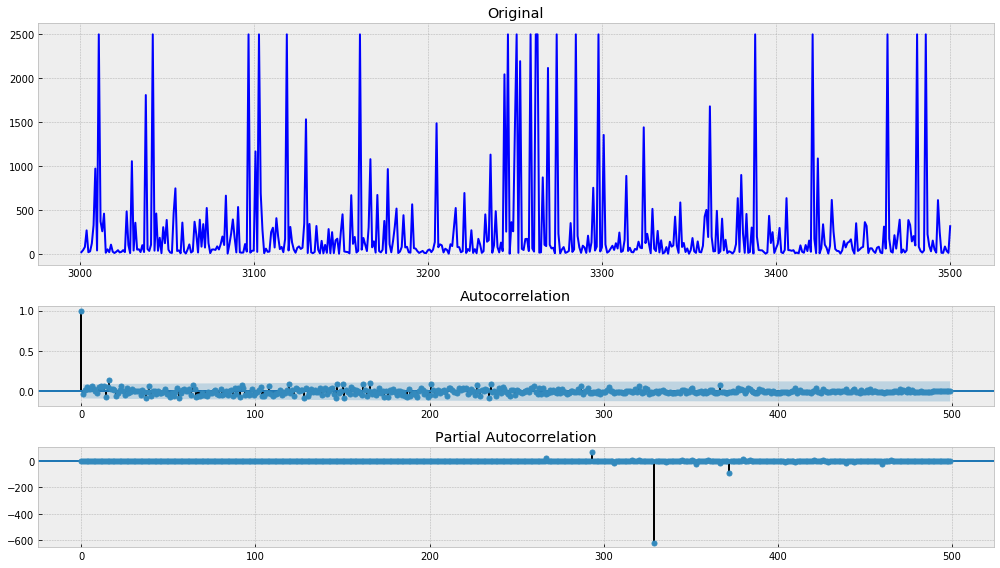

In [41]:
series=data[3000:3500]
series=series['p11']
tsplot(series)

Results of Dickey-Fuller Test:
Test Statistic                 -23.655491
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    499.000000
Critical Value (1%)             -3.443523
Critical Value (5%)             -2.867350
Critical Value (10%)            -2.569864
dtype: float64


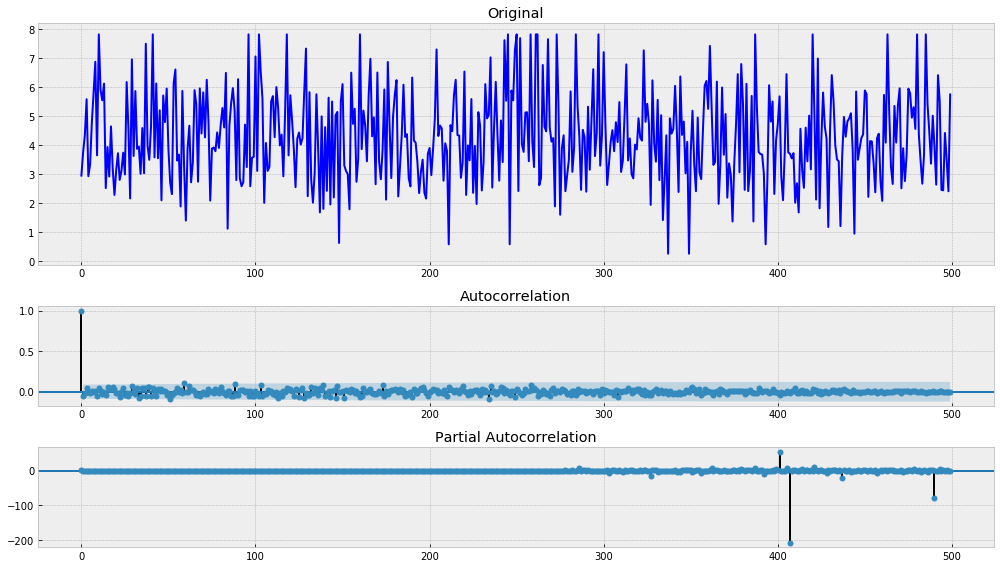

In [42]:
series = boxcox(series, 0)
tsplot(series)

Results of Dickey-Fuller Test:
Test Statistic                  -21.908070
p-value                           0.000000
#Lags Used                       16.000000
Number of Observations Used    9983.000000
Critical Value (1%)              -3.431005
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566924
dtype: float64


KeyboardInterrupt: 

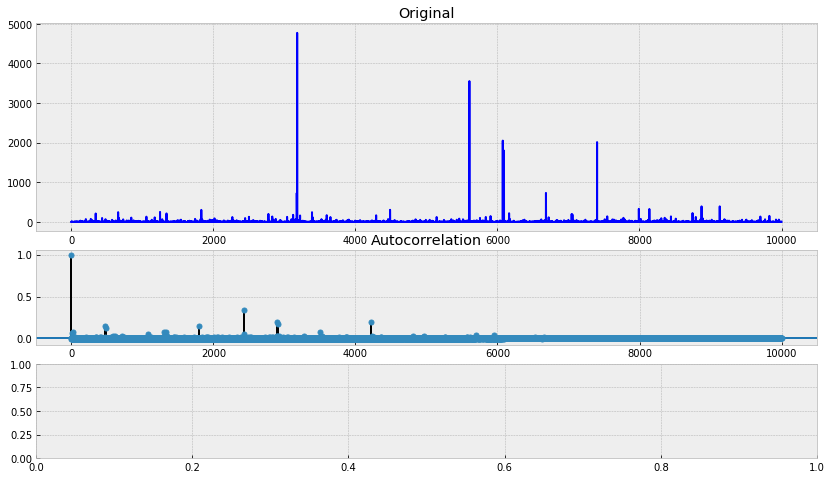

In [44]:
q=data[:10000]
series=q['Premium']
tsplot(series)

In [46]:
data.describe()

,Premium,Other,Bid,p11,p12,p13,p21,p22,p23,p24,agg,mean,target
count,192795.000000,192795.000000,192795.000000,192795.000000,192795.000000,192795.000000,192795.000000,192795.000000,192795.000000,192795.000000,1.927950e+05,192795.000000,192795.000000
mean,5.222962,5.795643,84.922822,253.636926,146.574285,106.525048,84.045648,78.660657,52.024901,39.516636,1.682788e+21,108.712014,-0.572681
std,40.150183,220.059518,197.318957,499.983992,361.874762,296.291858,249.728914,228.729185,177.085304,142.231754,2.546889e+22,252.819383,219.870882
min,1.000000,0.000000,0.210000,0.096667,0.056667,0.050000,0.050000,0.010000,0.010000,0.010000,2.402400e-11,0.046286,-63359.000000
25%,1.000000,0.000000,13.200000,26.750000,16.000000,12.250000,10.400000,7.950000,4.316667,2.766667,5.271545e+06,13.252381,1.000000
50%,2.000000,0.000000,30.790000,72.366667,39.183333,28.716667,23.816667,19.700000,11.766667,8.400000,2.862983e+09,31.619048,1.000000
75%,3.000000,1.000000,75.615000,221.150000,112.491667,78.300000,61.616667,57.700000,35.466667,26.083333,4.371601e+12,91.292857,3.000000
max,6513.000000,63546.000000,2500.000000,6162.833333,2500.100000,2500.100000,2500.100000,2500.100000,2500.100000,2500.100000,6.105225e+23,2500.100000,6502.000000


In [78]:
import statistics as s
print(s.median(data['Premium']))
print(s.median(data['Other']))

2.0
0.0


In [135]:
nd=data[data['target']>0]
nd=nd[nd['target']<100]
print(len(data))
print(len(nd))

192795
159627


In [136]:
y=nd['target']

In [137]:
del nd['target']
del nd['Premium']
del nd['Other']

In [138]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(nd, y, test_size=0.30, random_state=42)

In [139]:
nd=np.log(nd)

In [140]:
y=np.log(y)

In [141]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(X_train, y_train)

y_pred=model.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(cross_val_score(model, X_train, y_train))
#print(model.feature_importances_)
#print (model.intercept_, model.coef_)

47.43832072439322
[0.00461858 0.00525081 0.00294391]


In [146]:
print (model.coef_)

[7.72343241e-43 0.00000000e+00 7.44343554e-43 5.81906255e-43
 4.52005665e-43 3.65198078e-43 2.71557936e-43 2.09210884e-43
 1.87169371e-23 5.15420834e-43]


# Модель сильно ошибается.
# Как видим из коэфициентов модели, ставки конкурентов не влияют на финальный таргет (разница между премиум ставкой и другими)

In [142]:

from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)

y_pred=regr.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(cross_val_score(regr, X_train, y_train))
#print(model.feature_importances_)

46.735968787584724
[0.01702958 0.0196473  0.01495783]


IndexError: invalid index

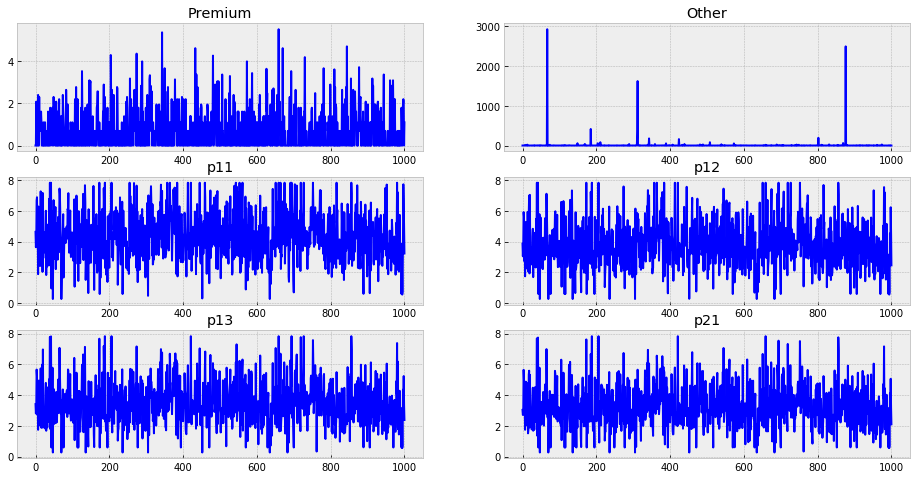

In [119]:

for i in data.columns:
    try:
        data[i]=data[i].astype(str)
        data[i] = [x.replace(',', '.') for x in data[i]]
        data[i]=data[i].astype(float)
        data[i]=boxcox(data[i], 0)
    except:
        next

all_series = {
    "Premium": data["Premium"][:1000],
    "Other": data["Other"][:1000],
    "p11": data["p11"][:1000],
    "p12": data["p12"][:1000],
    "p13": data["p13"][:1000],
    "p21": data["p21"][:1000],    
    "p22": data["p22"][:1000],
    "p23": data["p23"][:1000],
    "p24": data["p24"][:1000]

}

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()




In [116]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

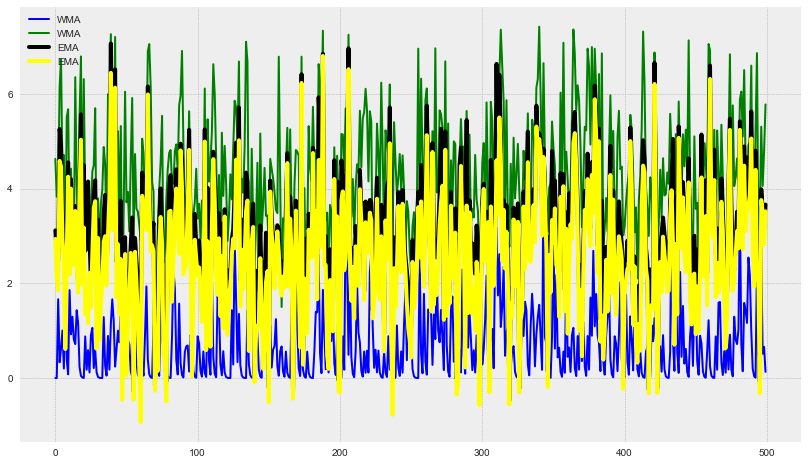

In [131]:
ema = exponential_moving_average(data["Premium"][:500], 0.8)
ema1 = exponential_moving_average(data["Other"][:500], 0.8)
ema2 = exponential_moving_average(data["p11"][:500], 0.8)
ema3 = exponential_moving_average(data["p22"][:500], 0.8)
ema4 = exponential_moving_average(data["p23"][:500], 0.8)



with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ema, color='blue', linewidth='2', label='WMA')
    #plt.plot(ema1, color='red', linewidth='2', label='WMA')
    plt.plot(ema2, color='green', linewidth='2', label='WMA')
    plt.plot(ema3, color='black', linewidth='4', label='EMA')
    plt.plot(ema4, color='yellow', linewidth='4', label='EMA')
    plt.legend()

In [132]:
ema1.corr(ema2)

0.1093985115043018